# Example of a user-defined model

## Model

-----------------------------

Example of a user-defined model reproducing the position of the eye during a saccade.

This model is a Gaussian curve.

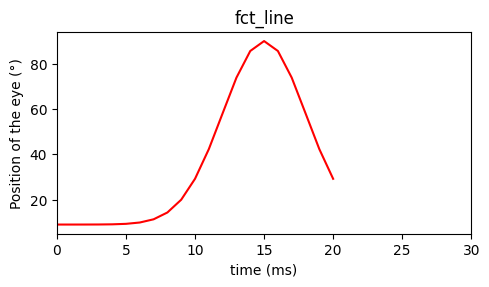

In [1]:
import numpy as np
def saccade_model(x, stime, etime, x0, xmax, tmax, sigma):

    """
    Model reproducing the position of the eye during the sacades.

    Parameters
    ----------
    x: ndarray
        Time of the function

    stime: float
        Start time of the curvature in ms
    etime: float
        End time of the curvature in ms

    x0: float
        Initial position of the beginning of the saccade in deg
    xmax: float
        Position maximum of the curvature in deg
    tmax: float
        Time of maximum position of the curvature in ms
    
    sigma: float
        Standard deviation of the curvature in ms

    
    Returns
    -------
    position: list
        Position of the eye during the sacades in deg
    """

    time = x
    tmax = tmax - stime
    
    if etime<=stime:
        return None
    
    else:
        def gausienne(t, xmax, tmax, sigma):
            f = (xmax-x0) * np.exp((-(t-tmax)**2)/(2*(sigma**2)))
            return  f

        saccade = []
        for t in time:
            if t <= stime:
                saccade.append(x0)
            elif t <= etime:
                saccade.append(x0 + gausienne(t-stime, xmax, tmax, sigma))
            else:
                saccade.append(np.nan)

        return saccade

#------------------------------------------------------------------------------
# Plot:
#------------------------------------------------------------------------------
fct = saccade_model(x=np.arange(30), stime=1, etime=20, x0=9, xmax=90, tmax=15,
                    sigma=3)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(10/2, 10/(1.681*2)))

axs.plot(fct, 'r')
axs.set_xlim([0, len(fct)])
axs.set_xlabel('time (ms)')
axs.set_ylabel('Position of the eye (°)')
axs.set_title('fct_line')

plt.tight_layout()
plt.show()

## Generate parameters

-----------------------------

In order to allow the parameters of this model to be fitted to the data, it is necessary to define a function to define the limits of these parameters during the fitting.

This function must return a python tuple containing two dictionaries:

- a first dictionary (called ``param`` here) which contains for each **parametric variable** of the function to be fitted a dictionary containing the following keys:
    - ``value`` - corresponding to the initial value that this variable should take
    - ``min`` - corresponding to the minimum value that this variable can take when fitted, or ``None`` for not defining a value
    - ``max`` - corresponding to the maximum value this variable can take when fitted, or `None` if you don't want to set a value
    - ``vary`` - can take three different values:
        - ``True`` - if you want the value of this variable to vary during fitting
        - ``False`` - if you want the value of this variable not to vary during the fitting and to retain the value set by ``value``.
        - ``'vary'`` - if you want to perform a two-step fit and you want the value of this variable not to vary during the first fit, but to be allowed to vary during the second fit.

- a second dictionary (called ``independent_vars`` here) which contains the values of each **non-parametric variable** (independent variable) in the function to be fitted.

In [2]:
def fct_generateParams(data, xname, trial, expname, stime, etime, **opt):

    """
    Allows you to generate parameters to fit the saccade model.

    Parameters
    ----------
    data: dict, or None (default None)
        Dictionary containing for each file the ``Data``, the
        ``Results``, the ``Events``, and the ``Settings``

    xname: str
        Name of the data to be transformed
    trial: int
        Number of the trial to be transformed
    expname: str
        Name of the particular experience to be transformed

    stime: int, or None (defaut None)
        Start time of the fitting (ms)
    etime: int, or None (default -280)
        End time of the fitting (ms)
    """
    # settings data
    settings = data[expname].Settings # settings data

    #----------------------------------------------------------------------
    # converts the time variables into the sampling frequency
    #----------------------------------------------------------------------
    if not 'SamplingFrequency' in settings.keys():
        raise SettingsError('SamplingFrequency', expname)

    SamplingFrequency = settings.SamplingFrequency.values[0]
    stime = round((stime/1000) * SamplingFrequency)
    etime = round((etime/1000) * SamplingFrequency)

    # data of the trial
    data_trial = data[expname].Data[data[expname].Data.trial==trial]

    # data of the saccade
    data_ = data_trial[xname].values[stime:etime]
    
    ###########################################################################
    # Dictionary containing the values of each parametric variable
    ###########################################################################
    params = dict()

    

    #==========================================================================
    # the variable corresponding to the start time of the curvature in ms
    #  takes an initial value at the time of fitting
    #  does not vary during the first fitting
    #  but can vary during the second fitting from a minimum value
    #  to a maximum value
    #==========================================================================
    params['stime'] = {'value':0,
                       'min':0,
                       'max':len(data_)/2,
                       'vary':'vary'}
    
    #==========================================================================
    # the variable corresponding to the end time of the curvature in ms
    #  takes an initial value at the time of fitting
    #  does not vary during the first fitting
    #  but can vary during the second fitting from a minimum value
    #  to a maximum value
    #==========================================================================
    params['etime'] = {'value':(3/4)*len(data_),
                       'min':len(data_)/2,
                       'max':len(data_),
                       'vary':'vary'}
    
    #==========================================================================
    # the variable corresponding to the initial position of the beginning
    # of the saccade in deg
    #  takes an initial value at the time of fitting
    #  does not vary during the first fitting
    #  but can vary during the second fitting from a minimum value
    #  to a maximum value
    #==========================================================================
    # initial position of the eye at the beginning of the saccade
    init_position_eye = data_[0]
    params['x0'] = {'value':init_position_eye,
                    'min':init_position_eye-0.1,
                    'max':init_position_eye+0.1,
                    'vary':'vary'}
    
    
    #==========================================================================
    # the variable corresponding to the position maximum of the curvature
    # in deg
    #  takes an initial value at the time of fitting
    #  but can vary from a minimum value to a maximum value
    #==========================================================================
    params['xmax'] = {'value':2,
                      'min':-5,
                      'max':5,
                      'vary':True}
    
    #==========================================================================
    # the variable corresponding to the time of maximum position of the
    # curvature in ms
    #  takes an initial value at the time of fitting
    #  but can vary from a minimum value to a maximum value
    #==========================================================================
    params['tmax'] = {'value':len(data_)/2,
                      'min':0,
                      'max':len(data_),
                      'vary':True}
    
    #==========================================================================
    # the variable corresponding to the standard deviation of the curvature
    # in ms
    #  takes an initial value at the time of fitting
    #  but can vary from a minimum value to a maximum value
    #==========================================================================
    params['sigma'] = {'value':3,
                      'min':0,
                      'max':10,
                      'vary':True}
    
    ###########################################################################
    # Dictionary containing the values of each non-parametric variable
    ###########################################################################
    independent_vars = dict()

    #==========================================================================
    # the variable corresponding to the time of the function (x)
    #  takes as value an arange list of the same length as the data
    #==========================================================================
    independent_vars['x'] = np.arange(len(data_))


    return params, independent_vars


## Test the parameters

-----------------------------

{'fit': array([nan, nan, nan, ..., nan, nan, nan]), 'values_fit': [{'stime': 9.000003362280948, 'etime': 28.560243250975155, 'x0': -1.8262506127876932, 'xmax': -0.1750096659275684, 'tmax': 23.577095444887377, 'sigma': 6.757723412715714}, {'stime': 12.906447252092695, 'etime': 27.426530130853724, 'x0': 0.19334149774097087, 'xmax': 3.521394212834121, 'tmax': 27.52277798748775, 'sigma': 7.197489809615016}], 'FitStatistics': [{'nfev': 1321, 'chisqr': 0.07633215893713165, 'redchi': 0.0033187895190057238, 'aic': -160.25874659981343, 'bic': -152.0549716198946}, {'nfev': 1159, 'chisqr': 0.14735235924854562, 'redchi': 0.006697834511297528, 'aic': -134.919725929588, 'bic': -126.92649886853678}]}


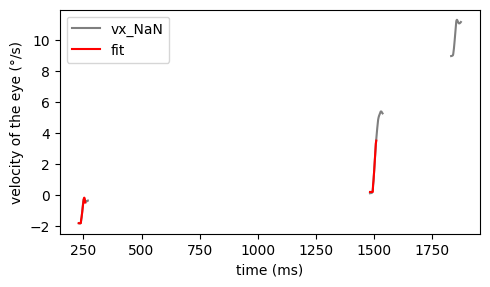

In [3]:
import ANEMO

Processing = ANEMO.ProcessingSaccades(dirpath='dataANEMO', sub='001')

#------------------------------------------------------------------------------
# Parameters:
#------------------------------------------------------------------------------
xname = 'saccade_deg' # The position of the saccades in degrees
trial = 8 # Number of the trial to be transformed
expname = 'sub-001' # Name of the particular experience to be transformed
                    # or list(PreProcessing.data.keys())[0]
model = saccade_model # Model equation
generate_params = fct_generateParams # Function generating parameters to perform
                                     # the fitting
stime = None # Start time of the fitting
etime = -280 # End time of the fitting
step_fit = 2 # Number of steps for the fit
# Dictionary containing the parameters for the generate_params function
arg_generate_params = dict(eventName_TargetOn='TargetOn',
                           eventName_dir_target='dir_target') 
toxname = None # Name of the data to be saved
return_ = True # If True returns the value, else saves it in results and data

#------------------------------------------------------------------------------
# to apply the function:
#------------------------------------------------------------------------------
Fit = Processing.Trial.Fit(xname=xname,
                           trial=trial,
                           expname=expname,
                           model=model,
                           generate_params=generate_params,
                           stime=stime,
                           etime=etime,
                           step_fit=step_fit,
                           arg_generate_params=arg_generate_params,
                           toxname=toxname,
                           return_=return_)
print(Fit)

#---------------------------------------------------------------------------
# to retrieve the raw data:
#---------------------------------------------------------------------------
data_exp = Processing.data[expname]
data = data_exp.Data
vx_NaN = data[data.trial==trial][xname].values

#---------------------------------------------------------------------------
# Plot:
#---------------------------------------------------------------------------
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(10/2, 10/(1.681*2)))

axs.plot(vx_NaN, 'k', alpha=.5, label='vx_NaN')
axs.plot(Fit['fit'], 'r', label='fit')
axs.set_xlabel('time (ms)')
axs.set_ylabel('velocity of the eye (°/s)')
axs.legend()

plt.tight_layout()
plt.show()

## Run it on a data set

----------------------------

In [4]:
import ANEMO

Processing = ANEMO.ProcessingSaccades(dirpath='dataANEMO', sub='001')

#---------------------------------------------------------------------------
# Parameters:
#---------------------------------------------------------------------------
xname = 'saccade_deg' # The position of the saccades in degrees
model = saccade_model # Model equation
generate_params = fct_generateParams # Function generating parameters to
                                     # perform the fitting
stime = None # Start time of the fitting
etime = -280 # End time of the fitting
step_fit = 2 # Number of steps for the fit
# Dictionary containing the parameters for the generate_params function
arg_generate_params = dict(eventName_TargetOn='TargetOn',
                           eventName_dir_target='dir_target') 
toxname = None # Name of the data to be saved
expnames = 'sub-001' # Name of the particular experience to be transformed
                     # or list(PreProcessing.data.keys())[0]
trials = trials = list(range(1, 16)) # List of the trial to be transformed
recalculate = False # Allows you to indicate if you want to force the
                    # calculation on the trials already processed
    
#------------------------------------------------------------------------------
# to apply the function:
#------------------------------------------------------------------------------
Processing.Data.Fit(xname=xname,
                    model=model,
                    generate_params=generate_params,
                    stime=stime,
                    etime=etime,
                    step_fit=step_fit,
                    arg_generate_params=arg_generate_params,
                    toxname=toxname,
                    expnames=expnames,
                    trials=trials,
                    recalculate=recalculate)

calculates Fit_saccade_model from the file sub-001... finished
save data... finished
